# Initialization cell

In [1]:
! pip install python-dotenv
! pip install pymorphy2 nltk scikit-learn
! pip install catboost
! pip install xgboost
! pip install -U scikit-learn

In [64]:
import pandas as pd
import numpy as np

import gdown
import os
import json

from dataclasses import dataclass
from typing import Optional
from dotenv import load_dotenv

import pymorphy2
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error

from tqdm import tqdm
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

[nltk_data] Downloading package punkt to /home/kitsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kitsu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preporation cell

In [3]:
ROOT_DIR: str = os.path.dirname(os.path.abspath(os.curdir))
DATASET_PATH: str = f"{ROOT_DIR}/source_data/superset_hr.xlsx"
SKILLS_JSON_PATH: str = f"{ROOT_DIR}/source_data/skills_dictionary.json"
GOOGLE_COLAB_PATH: str = '/content/superset_hr.xlsx'

load_dotenv()
SKILL_DICT_URL = os.environ.get('SKILL_DICT_URL')
DATASET_URL = os.environ.get('DATASET_V2_URL')

if DATASET_URL is None:
    print('>>> .env was not found!', end='\n\n')
    DATASET_URL = input('>>> Provide DATASET url for downloading: ')

    if SKILL_DICT_URL is None: SKILL_DICT_URL = input('>>> Provide JSON url for downloading: ')

In [4]:
def get_skill_dict() -> dict[str: list[int]]:
    try:
        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    except FileNotFoundError:
        print(f"Can't open file from path: {SKILLS_JSON_PATH}", end='\n\n')
        file_name = gdown.download(SKILL_DICT_URL, fuzzy=True)
        os.makedirs(os.path.dirname(SKILLS_JSON_PATH), exist_ok=True)
        os.rename(os.path.abspath(file_name), SKILLS_JSON_PATH)
        print(f'Moved to: {SKILLS_JSON_PATH}', end='\n\n')
        
        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    return data


def get_original_dataframe() -> pd.DataFrame:
    try:
        df = pd.read_excel(DATASET_PATH)
    except FileNotFoundError:
        try:
            print(f"Can't open file from path: {DATASET_PATH}", end='\n\n')
            df = pd.read_excel(GOOGLE_COLAB_PATH)
        except FileNotFoundError:
            print(f"Can't open file from path: {GOOGLE_COLAB_PATH}", end='\n\n')
            file_name = gdown.download(DATASET_URL, fuzzy=True)
            os.makedirs(os.path.dirname(DATASET_PATH), exist_ok=True)
            os.rename(os.path.abspath(file_name), DATASET_PATH)
            print(f'Moved to: {DATASET_PATH}', end='\n\n')
            df = pd.read_excel(DATASET_PATH)
    finally:
        print('Success!')
        return df

In [5]:
skills_dict = get_skill_dict()

In [29]:
df_original = get_original_dataframe()

Success!


In [30]:
print(df_original.shape)
df_original.sample(3)

(188833, 21)


,id,income_name,name,published_at,created_at,collected_at,url,area__name,salary__currency,salary__gross,...,address__city,schedule__name,grade,employment__name,key_skills__names,languages__names,exchange_rate,salary_from_gross,salary_to_gross,salary_average
174441,102419386,IT Project manager,Руководитель проектов IT (продуктовая разработ...,2024-06-27T11:15:26+0300,2024-06-27T11:15:26+0300,2024-06-27 03:07:49.680,https://api.hh.ru/vacancies/102419386?host=hh.ru,Москва,NaN,NaN,...,NaN,Гибкий график,Middle (3-6),Полная занятость,[],[],NaN,NaN,NaN,NaN
45106,93492101,DevOps,DevOps-инженер,2024-03-11T10:30:14+0300,2024-03-11T10:30:14+0300,2024-03-15 15:11:26.746,https://api.hh.ru/vacancies/93492101?host=hh.ru,Москва,NaN,NaN,...,Москва,Полный день,Junior (1-3),Полная занятость,"['CI/CD', 'Linux', 'SQL', 'Kubernetis']",[],NaN,NaN,NaN,NaN
23220,92104715,Специалист технической поддержки,Выездной инженер технической поддержки,2024-01-24T07:19:50+0300,2024-01-24T07:19:50+0300,2024-02-21 19:47:15.429,https://api.hh.ru/vacancies/92104715?host=hh.ru,Саранск,RUR,0.0,...,NaN,Полный день,Junior (1-3),Полная занятость,"['Настройка ПК', 'Ремонт ПК', 'Работа с оргтех...",[],1.0,50850.0,NaN,NaN


# Function & utils cell

In [78]:
def print_df_info(df: pd.DataFrame) -> None:
    print(f"Shape: {df.shape}")
    print('-' * 50)
    display(df.sample(3))
    print('-' * 50)
    display(df.info())


def create_new_cities(df: pd.DataFrame, threshold: int = 75) -> pd.DataFrame:
    df_new = df.copy()
    
    cities = df_new['area__name'].unique()
    city_counts = df_new['area__name'].value_counts()
    N_rows = df_new.shape[0]
    ratios = {city: city_counts[city] / N_rows for city in cities}

    answer = []
    all_percentage = 0
    sorted_dict = {k: v for k, v in sorted(ratios.items(), key=lambda item: item[1], reverse=True)}
    for label, pct in sorted_dict.items():
        all_percentage += pct * 100
        if all_percentage < threshold:
            answer.append(label)

    print("Answer", answer)
        
    df_new.loc[~df_new['area__name'].isin(answer), 'area__name'] = 'Малый город'
    return df_new


def get_clear_df_version(df: pd.DataFrame, save_cols = list[str]) -> pd.DataFrame:
    df_new = df[save_cols].copy()

    df_new = df_new.dropna(subset=['salary_from_gross', 'salary_to_gross', 'salary_average'], how='all')
    df_new = df_new.dropna(subset=['income_name'])

    df_new['not_rur'] = df_new['exchange_rate'] != 1
    df_new['not_rur'] = df_new['not_rur'].astype(int)
    df_new = df_new.drop(['salary__currency', 'exchange_rate'], axis=1)

    return df_new


def get_difference_percentiles(df: pd.DataFrame) -> tuple[float, float, float]:
    filtered_df = df.dropna(subset=['salary_from_gross', 'salary_to_gross']).copy()
    filtered_df.loc[:, 'difference'] = filtered_df['salary_to_gross'] - filtered_df['salary_from_gross']
    condition = filtered_df['difference'] > 0.8 * filtered_df['salary_to_gross']
    filtered_df.loc[condition, ['salary_from_gross', 'difference']] = np.nan

    filtered_df = filtered_df.dropna(subset=['salary_from_gross', 'salary_to_gross'])

    filtered_df = filtered_df[filtered_df['salary_from_gross'] >= 1000]
    filtered_df = filtered_df[filtered_df['salary_to_gross'] >= 10000]

    filtered_df.loc[:, 'difference_ratio'] = np.where(filtered_df['salary_to_gross'] != 0, 
                                                      filtered_df['difference'] / filtered_df['salary_to_gross'], 
                                                      np.nan)

    perc25 = filtered_df['difference_ratio'].quantile(0.25)
    perc50 = filtered_df['difference_ratio'].quantile(0.50)
    perc75 = filtered_df['difference_ratio'].quantile(0.75)

    return perc25, perc50, perc75


def fill_na_salary(df: pd.DataFrame, coef) -> pd.DataFrame:
    result_df = df.copy()
    result_df['salary_to_gross'] = result_df['salary_to_gross'].fillna(result_df['salary_from_gross'] / (1-coef))
    result_df['salary_from_gross'] = result_df['salary_from_gross'].fillna(result_df['salary_to_gross'] * (1-coef))
    result_df['salary_average'] = result_df['salary_average'].fillna((result_df['salary_to_gross'] + result_df['salary_from_gross']) / 2)
    
    result_df[['salary_to_gross', 'salary_from_gross', 'salary_average']] = result_df[['salary_to_gross', 'salary_from_gross', 'salary_average']].astype(float)
    return result_df


def exctract_features(df: pd.DataFrame, drop_param: Optional[str] = None) -> pd.DataFrame:
    df.rename(columns={'income_name': 'income__name'}, inplace=True)
    transformers = [
        ('schedule_name', OneHotEncoder(sparse_output=False, drop=drop_param), ['schedule__name']),
        ('grade', OneHotEncoder(sparse_output=False, drop=drop_param), ['grade']),
        ('income_name', OneHotEncoder(sparse_output=False, drop=drop_param), ['income__name']),
        ('area_name', OneHotEncoder(sparse_output=False, drop=drop_param), ['area__name'])
    ]

    pipeline = Pipeline(steps=[
        ('column_transformer', ColumnTransformer(transformers=transformers, remainder='passthrough'))
    ])

    display(pipeline)

    df_transformed = pipeline.fit_transform(df)
    column_names = pipeline.named_steps['column_transformer'].get_feature_names_out()

    strings_to_replace = ['remainder__','schedule__name_','income__name_', 'area__name_']
    for string in strings_to_replace:
        column_names = [x.replace(string, '') for x in column_names]
    column_names = [x.replace('grade__grade_', 'grade_') for x in column_names]

    df_new = pd.DataFrame(df_transformed, columns=column_names)

    return df_new


def convert_skills(skill_string: str, skills_dict: dict) -> tuple[list[str], list[str]]:
    try:
        skill_list = eval(skill_string)
        if not isinstance(skill_list, list):
            return np.nan, 0, []
    except:
        return np.nan, 0, []

    converted_skills = []
    unconverted_skills = []

    for skill in skill_list:
        found = False
        for main_skill, variations in skills_dict.items():
            if skill in variations:
                converted_skills.append(main_skill)
                found = True
                break
        if not found:
            unconverted_skills.append(skill)

    return converted_skills, unconverted_skills


def preprocess_key_skills(df: pd.DataFrame, s_dict: dict[str: list[str]], 
                          with_skills: bool = True, with_grade: bool = True, with_area: bool = True) -> pd.DataFrame:
    df_new = df.copy()

    if not with_skills:
        df_new = df_new.drop(['not_rur'], axis=1)
    else:
        df_new[['skills', 'unconverted_skills']] = df_new['key_skills__names'].apply(
        lambda x: pd.Series(convert_skills(x, s_dict))
    )

    df_new = df_new.drop(['key_skills__names'], axis=1)
    
    if not with_grade:
        df_new = df_new.drop(columns = df.filter(like='grade').columns, axis=1)

    if not with_area:
        df_new = df_new.drop(columns = df.filter(like='area_name').columns, axis=1) 

    return df_new


morph = pymorphy2.MorphAnalyzer()
nltk_stop_words  = set(stopwords.words('russian'))
custom_words = {',', ':', 'работа', 'активный', 'язык', 'навык', 
                'деловой', 'ведение', 'проведение', 'презентация', 'грамотный'}
stop_words = nltk_stop_words.union(custom_words)


def tokenize_and_lemmatize(skill_list: list[str]) -> list[str]:
    tokens = []
    for skill in skill_list:
        words = word_tokenize(skill)
        lemmas = [morph.parse(word.lower())[0].normal_form for word in words if word.lower() not in stop_words]
        tokens.extend(lemmas)
    return tokens


def process_skills(df: pd.DataFrame, freq_cutoff: int = 100, add_unprocessed = False) -> pd.DataFrame:
    df_processed = df.copy()

    def prepare_skills(df: pd.DataFrame, col):
        df_new = df.copy()
        df_new[col] = df_new[col].apply(tokenize_and_lemmatize)
        counts = df_new[col].explode().value_counts()
        frequent = counts[counts >= freq_cutoff].index
        df_new[col] = df_new[col].apply(lambda skills: [skill for skill in skills if skill in frequent])

        return df_new  
    
    if add_unprocessed:
        df_processed = prepare_skills(df_processed, 'skills')  
        df_processed = prepare_skills(df_processed, 'unconverted_skills')
        df_processed['skills_plus'] = df_processed['skills'] + df_processed['unconverted_skills'] 
    else:
        df_processed['skills_plus'] = df_processed['skills']

    df_processed = df_processed[df_processed['skills_plus'].apply(lambda x: len(x) > 0)]

    df_processed = df_processed.drop(['unconverted_skills',
                                      'skills',
                                      'not_rur'
                                      ], axis = 1)
    return df_processed


def vectorize_PCA_skills(df: pd.DataFrame, n_components: int = 100, PCA_enable: bool = True, add_unprocessed = False) -> pd.DataFrame:
    df_vect = df.copy()
    if not add_unprocessed:
        vectorizer = TfidfVectorizer(analyzer=lambda x: x)
    else:
        df_vect['skills_plus'] = df_vect['skills_plus'].apply(lambda x: ' '.join(x))
        vectorizer = TfidfVectorizer()

    display(vectorizer)
    skills_tfidf = vectorizer.fit_transform(df_vect['skills_plus'])
    skills_df = pd.DataFrame(skills_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    df_vect = df_vect.reset_index()
    
    if PCA_enable:
        pca = PCA(n_components)
        display(pca)
        skills_pca = pca.fit_transform(skills_df)
        skills_pca_df = pd.DataFrame(skills_pca, columns=[f'component_{i+1}' for i in range(skills_pca.shape[1])])        
        df_merged = pd.concat([df_vect, skills_pca_df], axis=1)
    else:
        df_merged = pd.concat([df_vect, skills_df], axis=1)

    df_merged = df_merged.drop(['skills_plus', 'index'], axis=1)
    df_merged[['salary_from_gross',
               'salary_to_gross',
               'salary_average']] = df_merged[['salary_from_gross',
                                               'salary_to_gross',
                                               'salary_average']].astype(float)

    return df_merged

# Preporocessing Pipleline

In [79]:
@dataclass
class PreprocessParams:
    FREQ_CUTOFF: int = 1000
    DROP_PARAM_ONE_HOT = 'first'
    THRESHOLD_CITIES: int = 50
    PERC_NUMBER: int = 0  # 0 - 25% | 1 - 50% | 2 - 75%
    IS_PCA_ENABLE: bool = False
    N_COMPONENTS: int = 100
    ADD_UNPROCESSED: bool = False
    WITH_SKILLS: bool = True
    WITH_GRADE: bool = True
    WITH_AREA: bool = True

    def __repr__(self) -> str:
        return (
            f"Preprocess Params:\n"
            f"--------------------------\n"
            f"* {self.FREQ_CUTOFF=}\n"
            f"* {self.THRESHOLD_CITIES=}\n"
            f"* {self.DROP_PARAM_ONE_HOT=}\n"
            f"* {self.PERC_NUMBER=}\n"
            f"* {self.IS_PCA_ENABLE=}\n"
            f"* {self.N_COMPONENTS=}\n"
            f"* {self.ADD_UNPROCESSED=}\n"
            f"* {self.WITH_SKILLS=}\n"
            f"* {self.WITH_GRADE=}\n"
            f"* {self.WITH_AREA=}\n"
        )

SAVE_COLS = ['income_name', 'area__name', 'schedule__name', 'grade',
            'key_skills__names', 'salary__currency',
            'exchange_rate', 'salary_from_gross', 'salary_to_gross', 'salary_average'
]


def get_preprocess_pipeline(params: PreprocessParams) -> Pipeline:
    basic_pipe = Pipeline(steps=[
            ('clear_df', FunctionTransformer(
                func=lambda df: get_clear_df_version(df, SAVE_COLS))),

            ('create_new_cities', FunctionTransformer(
                func=lambda df: create_new_cities(df, params.THRESHOLD_CITIES))),

            ('fill_na_salary', FunctionTransformer(
                func=lambda df: fill_na_salary(df, get_difference_percentiles(df)[params.PERC_NUMBER])
            )),

            ('extract_features', FunctionTransformer(
                func=lambda df: exctract_features(df, params.DROP_PARAM_ONE_HOT))),

            ('preprocess_key_skills', FunctionTransformer(
                func=lambda df: preprocess_key_skills(df, skills_dict, 
                                                      params.WITH_SKILLS, 
                                                      params.WITH_GRADE, 
                                                      params.WITH_AREA)
            )),
            
            ], verbose=True).set_output(transform="pandas")
    
    pipe_skill_vectorize = Pipeline(steps=[
        ('process_skills', FunctionTransformer(
                func=lambda df: process_skills(df, 
                                               params.FREQ_CUTOFF, 
                                               params.ADD_UNPROCESSED),
            )),

        ('vectorize_PCA_skills', FunctionTransformer(
                func=lambda df: vectorize_PCA_skills(df, 
                                                     params.N_COMPONENTS, 
                                                     params.IS_PCA_ENABLE, 
                                                     params.ADD_UNPROCESSED)
            ))

        ],verbose=False).set_output(transform="pandas")

    if params.WITH_SKILLS:
        pipe = Pipeline(steps=[
            ('basic_pipe', basic_pipe),
            ('skill_vectorize', pipe_skill_vectorize)
            ],
            verbose=True).set_output(transform="pandas")
    else:
        pipe = basic_pipe

    print(params, end='\n\n')
    display(pipe)
    return pipe

In [83]:
pipeline_preprocess: Pipeline = get_preprocess_pipeline(PreprocessParams(WITH_SKILLS=True,
                                                                        WITH_GRADE=True, 
                                                                        WITH_AREA=True,
                                                                        IS_PCA_ENABLE=True))

df_after_preprocess: pd.DataFrame = pipeline_preprocess.fit_transform(df_original).astype(float)

Preprocess Params:
--------------------------
* self.FREQ_CUTOFF=1000
* self.THRESHOLD_CITIES=50
* self.DROP_PARAM_ONE_HOT='first'
* self.PERC_NUMBER=0
* self.IS_PCA_ENABLE=True
* self.N_COMPONENTS=100
* self.ADD_UNPROCESSED=False
* self.WITH_SKILLS=True
* self.WITH_GRADE=True
* self.WITH_AREA=True




Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  FunctionTransformer(func=<function get_preprocess_pipeline.<locals>.<lambda> at 0x7f5d501a8ca0>)),
                                 ('create_new_cities',
                                  FunctionTransformer(func=<function get_preprocess_pipeline.<locals>.<lambda> at 0x7f5d501aa3b0>)),
                                 ('fill_na_salary',
                                  FunctionTransformer(func=<function get_preprocess_pipeline.<loca...
                                  FunctionTransformer(func=<function get_preprocess_pipeline.<locals>.<lambda> at 0x7f5d501ab880>))],
                          verbose=True)),
                ('skill_vectorize',
                 Pipeline(steps=[('process_skills',
                                  FunctionTransformer(func=<function get_preprocess_pipeline.<locals>.<lambda> at 0x7f5d501aac20>)),
                                 ('vectorize_PCA_skills',
                                  FunctionTransformer(func=<function get_preprocess_pipeline.<locals>.<lambda> at 0x7f5d501abd90>))]))],
         verbose=True)

[Pipeline] .......... (step 1 of 5) Processing clear_df, total=   0.0s
Answer ['Москва', 'Санкт-Петербург', 'Екатеринбург', 'Новосибирск', 'Краснодар', 'Казань', 'Нижний Новгород']
[Pipeline] . (step 2 of 5) Processing create_new_cities, total=   0.0s
[Pipeline] .... (step 3 of 5) Processing fill_na_salary, total=   0.0s


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('schedule_name',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['schedule__name']),
                                                 ('grade',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['grade']),
                                                 ('income_name',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['income__name']),
                                                 ('area_name',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['area__name'])]))])

[Pipeline] .. (step 4 of 5) Processing extract_features, total=   0.1s
[Pipeline]  (step 5 of 5) Processing preprocess_key_skills, total=  15.0s
[Pipeline] ........ (step 1 of 2) Processing basic_pipe, total=  15.3s


TfidfVectorizer(analyzer=<function vectorize_PCA_skills.<locals>.<lambda> at 0x7f5d501abbe0>)

PCA(n_components=100)

[Pipeline] ... (step 2 of 2) Processing skill_vectorize, total=   1.8s


In [82]:
print_df_info(df_after_preprocess)

Shape: (50114, 473)
--------------------------------------------------


,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__1C оператор,income_name__1С администратор,income_name__1С аналитик,...,финансовый контроль,функциональное тестирование,художественный вкус,ценообразование,чувство вкуса,чувство стиля,эконометрика,экономика,экономический анализ,эксплуатационные документы
17639,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43566,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10835,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50114 entries, 0 to 50113
Columns: 473 entries, schedule_name__Гибкий график to эксплуатационные документы
dtypes: float64(473)
memory usage: 180.8 MB


None

# Fitting Model

In [14]:
RANDOM_STATE = 42

param_grid = [
        {
            'model': [Ridge(random_state=RANDOM_STATE)]
        },
        {
            'model': [CatBoostRegressor(verbose=False,
                                        random_state=RANDOM_STATE)]
        },
        {
            'model': [XGBRegressor(random_state=RANDOM_STATE)]
        },
        {
            'model': [RandomForestRegressor(verbose=False, n_jobs=-1, random_state=RANDOM_STATE)]
        },
        {
            'model': [DecisionTreeRegressor(random_state=RANDOM_STATE, 
                                            criterion='friedman_mse')]
        }
]

rmse = make_scorer(root_mean_squared_error)
mse = make_scorer(mean_squared_error)

def pipeline_train(data):
    X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'])
    y = data['salary_average']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

    best_models = {}

    for model_params in tqdm(param_grid):
        pipeline = Pipeline(steps=[
            ('model', model_params['model'])
        ])

        grid_search = GridSearchCV(pipeline, param_grid=model_params, cv=5, scoring=rmse)
        display(grid_search)
        grid_search.fit(X_train, y_train)

        y_pred = grid_search.predict(X_test)

        best_models[type(model_params['model']).__name__] = grid_search.best_estimator_
        print(f"Best parameters for {type(model_params['model']).__name__}: {grid_search.best_params_}")
        print(f"Best score for {type(model_params['model']).__name__}: {grid_search.best_score_}")

    return best_models

In [253]:
# results = pipeline_train(df_after_preprocess)

  0%|          | 0/5 [00:00<?, ?it/s]

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', [Ridge(random_state=42)])]),
             param_grid={'model': [Ridge(random_state=42)]},
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

 20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Best parameters for list: {'model': Ridge(random_state=42)}
Best score for list: 31760.15826890469


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        [<catboost.core.CatBoostRegressor object at 0x7fd9d9eeb6a0>])]),
             param_grid={'model': [<catboost.core.CatBoostRegressor object at 0x7fd9d9eeb6a0>]},
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

 40%|████      | 2/5 [00:32<00:56, 18.89s/it]

Best parameters for list: {'model': <catboost.core.CatBoostRegressor object at 0x7fd9d9eeb6a0>}
Best score for list: 28925.146052117772


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        [XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints...
                                                learning_rate=None,
                                                max_bin=None,
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=None,
                                                max_delta_step=None,
                                                max_depth=None, max_leaves=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                multi_strategy=None,
                                                n_estimators=None, n_jobs=None,
                                                num_parallel_tree=None,
                                                random_state=42, ...)]},
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

 60%|██████    | 3/5 [01:31<01:14, 37.46s/it]

Best parameters for list: {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)}
Best score for list: 29580.44977638084


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        [RandomForestRegressor(n_jobs=-1,
                                                               random_state=42,
                                                               verbose=False)])]),
             param_grid={'model': [RandomForestRegressor(n_jobs=-1,
                                                         random_state=42,
                                                         verbose=False)]},
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

 80%|████████  | 4/5 [04:58<01:44, 104.24s/it]

Best parameters for list: {'model': RandomForestRegressor(n_jobs=-1, random_state=42, verbose=False)}
Best score for list: 28679.763219176228


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        [DecisionTreeRegressor(criterion='friedman_mse',
                                                               random_state=42)])]),
             param_grid={'model': [DecisionTreeRegressor(criterion='friedman_mse',
                                                         random_state=42)]},
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

100%|██████████| 5/5 [05:26<00:00, 65.37s/it] 

Best parameters for list: {'model': DecisionTreeRegressor(criterion='friedman_mse', random_state=42)}
Best score for list: 38806.39852876267


In [15]:
import matplotlib.pyplot as plt

def train(data, estimator, n_top_features=40):
    X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'], axis=1)
    y = data['salary_average']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    print(root_mean_squared_error(y_test, y_pred))

    
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:n_top_features]
    top_importances = importances[top_indices]
    top_features = X.columns[top_indices]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(n_top_features), top_importances, align='center')
    plt.xticks(range(n_top_features), top_features, rotation=90)
    plt.xlim([-1, n_top_features])
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return estimator

27576.31515393108


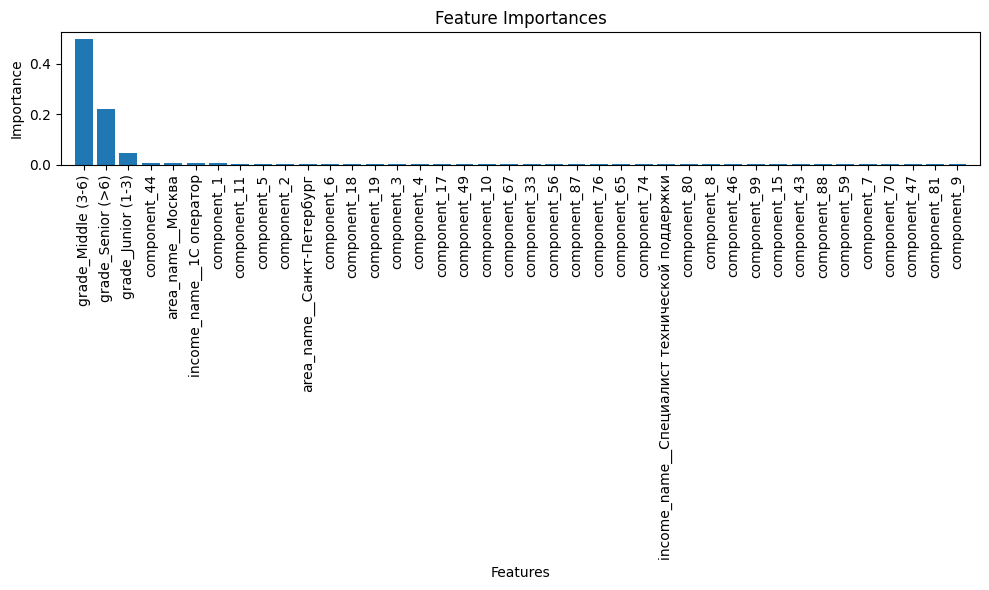

In [16]:
pretrained_model = train(df_after_preprocess, RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE))

# Test Prediction

In [268]:
def predict_random_from_category(model, data, num_samples = 3, category = None):

    if category == None:
        category = input('>>> Provide category for testing: ')

    for x in range(num_samples):

        random_cat_row = data[data[category] == 1].sample()

        true_salary = random_cat_row['salary_average'].item()
        true_low = random_cat_row['salary_from_gross'].item()
        true_high = random_cat_row['salary_to_gross'].item()

        X_sample = random_cat_row.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'])

        predicted_salary = model.predict(X_sample)[0]
        predicted_low = predicted_salary * 8 / 9 
        predicted_low = int(np.round(predicted_low, -2))
        predicted_high = predicted_salary * 10 / 9 
        predicted_high = int(np.round(predicted_high, -2))

        print(f"Истинная зарплата для случайной вакансии {x} в категории {category}:\n{true_low} -- {true_high}, среднее {true_salary}\n")
        print(f"Предсказанная зарплата:\n{predicted_low} -- {predicted_high}, среднее {predicted_salary}\n")
        print("____________________________________________________________________________________________\n")

In [272]:
predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Middle (3-6)')

Истинная зарплата для случайной вакансии 0 в категории grade_Middle (3-6):
200000.0 -- 250000.0, среднее 225000.0

Предсказанная зарплата:
198500 -- 248200, среднее 223350.64034411762

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Middle (3-6):
211309.99999999997 -- 248600.0, среднее 229955.0

Предсказанная зарплата:
246100 -- 307700, среднее 276888.58094607835

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Middle (3-6):
282500.0 -- 338999.9999999999, среднее 310749.9999999999

Предсказанная зарплата:
267400 -- 334200, среднее 300812.67401960783

____________________________________________________________________________________________



In [273]:
predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Junior (1-3)')

Истинная зарплата для случайной вакансии 0 в категории grade_Junior (1-3):
79099.99999999999 -- 93058.82352941176, среднее 86079.41176470587

Предсказанная зарплата:
78900 -- 98600, среднее 88744.86718823522

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Junior (1-3):
90399.99999999999 -- 113000.0, среднее 101700.0

Предсказанная зарплата:
85800 -- 107200, среднее 96496.51211764706

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Junior (1-3):
56499.99999999999 -- 66470.58823529413, среднее 61485.29411764706

Предсказанная зарплата:
61300 -- 76700, среднее 68986.88482352947

____________________________________________________________________________________________



In [274]:
predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Senior (>6)')

Истинная зарплата для случайной вакансии 0 в категории grade_Senior (>6):
250000.0 -- 350000.0, среднее 300000.0

Предсказанная зарплата:
239800 -- 299800, среднее 269794.5401368894

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Senior (>6):
226000.0 -- 265882.3529411765, среднее 245941.17647058825

Предсказанная зарплата:
255300 -- 319100, среднее 287164.7503529415

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Senior (>6):
339999.99999999994 -- 400000.0, среднее 370000.0

Предсказанная зарплата:
335900 -- 419800, среднее 377849.4348529412

____________________________________________________________________________________________



In [17]:
import pickle

with open('model.pkl','wb') as f:
    pickle.dump(pretrained_model, f)